In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
import sys
print(sys.modules['keras_retinanet'].__file__)
print(sys.modules['keras_resnet'].__file__)
print(sys.modules['keras'].__file__)

/home/kai/.local/lib/python3.5/site-packages/keras_retinanet-0.0.1-py3.5.egg/keras_retinanet/__init__.py
/home/kai/.local/lib/python3.5/site-packages/keras_resnet/__init__.py
/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/__init__.py


In [15]:
# model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
# model = keras.models.load_model('../snapshots/resnet50_csv_09.h5', custom_objects=custom_objects)
model = keras.models.load_model('../snapshots/resnet50_csv_49.h5', custom_objects=custom_objects)
# print(model.summary())

/usr/local/lib/python3.5/dist-packages/Keras-2.1.2-py3.5.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [ ]:
def add_noise(inData):
    result = np.random.normal(inData, scale=0.5).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

def set_to_zero(inData):
    result = np.zeros(inData.shape).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result



In [4]:
# Note: this is a huge dataset. Not needed if just doing inference from actual run images

# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation5Tiny.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname5.txt',
                val_image_data_generator,
                batch_size=10
            )

In [ ]:
# load image
index = np.random.randint(0,16800)
image = validation_generator.load_image(index)
print(image.shape)

In [9]:
# use this block to test against actual image
# image = cv2.imread("testImg/cellBaseRotated3.bmp.png")
#image = cv2.imread("C:\\Users\\Kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
#image = cv2.imread("//KAI-LAPTOP/Users/kai/study/robot_prototype/ur3Control/tmp/undistorted.png")
index = 0
image = cv2.imread("/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png")
print(image.shape)

(647, 884, 3)


In [ ]:
image = add_noise(image)

In [10]:

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
print(image.shape)
image, scale = validation_generator.resize_image(image)
print(image.shape)
annotations = validation_generator.load_annotations(index)

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)


(647, 884, 3)
(600, 820, 3)
0
/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_440_540_-5.png
0.9273570324574961
[[ 295.  525.  355.  585.   13.]
 [ 427.  424.  467.  464.   16.]]


In [11]:
# process image
start = time.time()
detections = None
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
print(predicted_labels[0:10])
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
print(scores[0:10])
# correct for image scale
detections[0, :, :4] /= scale


processing time:  1.0034031867980957
[17 16 13 15  9 14 13  0  0 17]
[ 0.99999702  0.99998617  0.99998355  0.99996293  0.98852831  0.9838081
  0.00742267  0.00700203  0.00679428  0.0067927 ]


## Physical measurement:

- center of left hole to edge clamp of ribbon cable: 9mm
- center of left hole to center of socket: 24.5mm
- center of left hole to center of right circuit feature: 36mm



17 546 295
16 645 283
13 485 345
15 397 375
9 602 378
14 324 351


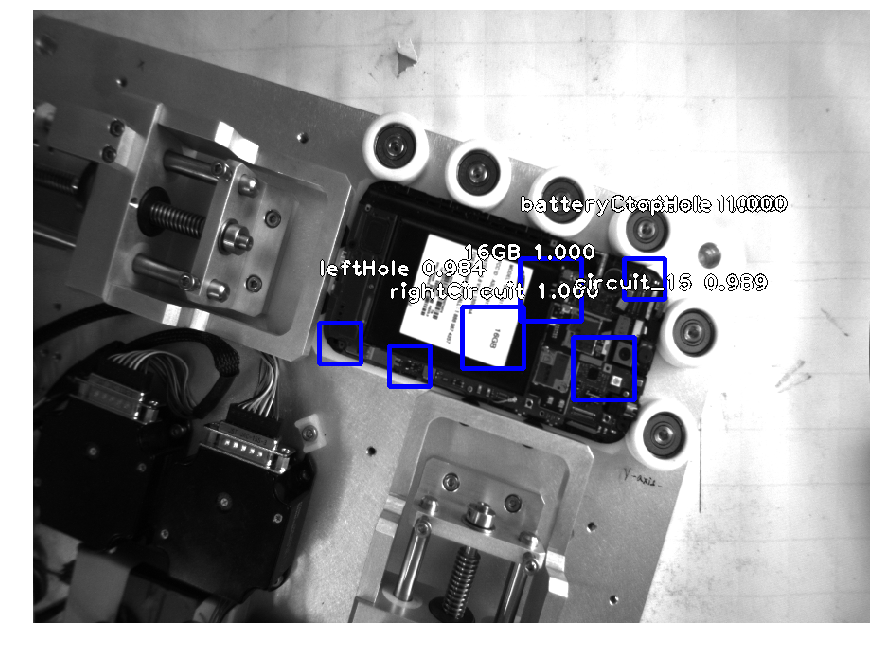

324 351 397 375


In [12]:

# visualize annotations
'''
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
'''

centerX = np.zeros(18, dtype=int)
centerY = np.zeros(18, dtype=int)

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    centerX[label] = b[0] + (b[2]-b[0])/2
    centerY[label] = b[1] + (b[3]-b[1])/2
    print(label, centerX[label], centerY[label])
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

print (centerX[14], centerY[14], centerX[15], centerY[15])


# Define function to return 2D pose from image file

## calculate the angle from at least 3 points:
- origin
- left hole
- top hole

| Name          | IDs           | base cordinates  | rel cordinates   | init angle   |
| ------------- |:-------------:|:----------------:|:----------------:|:------------:|
| origins       | 0-12          | (656, 250)       | (0, 0)           |
| 16GB          | 13            | (540, 255)       | (-126, 5)        |
| leftHole      | 14            | (394, 306)       | (-262, 56)       |
| rightCircuit  | 15            | (470, 306)       | (-186, 56)       |
| topHole       | 16            | (671, 155)       | (15, -95)        |
| batteryContact| 17            | (584, 193)       | (-72, -57)       |




In [5]:
initAngle = np.zeros(18, dtype=float)
initAngle[13] = math.atan2(5,-126) * 180.0/math.pi
initAngle[14] = math.atan2(56,-262) * 180.0/math.pi
initAngle[15] = math.atan2(56,-186) * 180.0/math.pi
initAngle[16] = math.atan2(-95,15) * 180.0/math.pi
initAngle[17] = math.atan2(-57, -72) * 180.0/math.pi

print(initAngle)

[   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.          177.72755027  167.93511559  163.24425107  -81.02737339
 -141.63251462]


In [6]:

def get2DPose(inFile):
    image = cv2.imread(inFile)
    print(image.shape)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = validation_generator.preprocess_image(image)
    print(image.shape)
    image, scale = validation_generator.resize_image(image)
    print(image.shape)
    print(scale)
    
    # process image
    start = time.time()
    detections = None
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    # correct for image scale
    detections[0, :, :4] /= scale
    
    b = None
    foundTarget = False
    angle = None
    centerX = np.zeros(18, dtype=int)
    centerY = np.zeros(18, dtype=int)

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
            
        b = detections[0, idx, :4].astype(int)
        if label <= 12:
            foundTarget = True
            originX = (b[0]+b[2])/2
            originY = (b[1]+b[3])/2
            angle = int(validation_generator.label_to_name(label)[8:])

           
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

        centerX[label] = (b[2]+b[0])/2
        centerY[label] = (b[3]+b[1])/2
        print(label, centerX[label], centerY[label])
        
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    if not foundTarget:
        return -999, -999, -999
    
    
    print("origin and angle", originX, originY, angle)
    
    totalAngle = 0.0
    totalCount = 0
    if not foundTarget:
        angleAvg = angle
    else:
        # average only labels 14 and 16
        for labelID in range(14, 17, 2):
            if centerX[labelID] != 0 and centerY[labelID] != 0:
                featureAngle = (math.atan2(centerY[labelID] - originY, centerX[labelID] -originX)) * 180.0 / math.pi - initAngle[labelID]
                if featureAngle < -180:
                    featureAngle = featureAngle + 360
                elif featureAngle > 180:
                    featureAngle = 360 - featureAngle
                print("featureAngle:", labelID, centerX[labelID], centerY[labelID], featureAngle)
                totalAngle = totalAngle + featureAngle
                totalCount = totalCount + 1
    
        angleAvg = totalAngle / totalCount
    print("returning", originX, originY, angleAvg)
    return originX, originY, angleAvg

In [19]:
method = eval('cv2.TM_CCOEFF_NORMED')

In [21]:
import os
import cv2

def getMatchedOrigin(inFile, angle, xCenter, yCenter):
    command = "convert origin.png -distort SRT '10,10,1,{},10,10' -alpha off tmp_origin_out.png".format(angle)
    print(command)
    result = os.system(command)
    print(result)
    cropped_length = 20
    origin_length = 10 # length on either side of origin

    img = cv2.imread(inFile)
    template = cv2.imread('tmp_origin_out.png')

    img = img[yCenter-cropped_length:yCenter+cropped_length, xCenter-cropped_length:xCenter+cropped_length]
    # plt.imsave("tmp_cropped.png", img)

    res = cv2.matchTemplate(img, template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    print(max_val)
    print(max_loc)
    print(max_loc[0]+origin_length, max_loc[1]+origin_length)

    xResult = xCenter-cropped_length+max_loc[0]+origin_length
    yResult = yCenter-cropped_length+max_loc[1]+origin_length
    print(xResult, yResult)
    return xResult, yResult



# Create Server to respond to identification request

In [9]:
import socket
import time

HOST = "192.168.1.116" #The remote host
PORT = 3001 # The same port as used by the server
print("Starting 2d id program")

Starting 2d id program


In [10]:
returnVal = None

In [11]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation5Tiny.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname5.txt',
                val_image_data_generator,
                batch_size=10
            )

Waiting for connections...
Connected
received: acquireCircuitOrigin
(647, 884, 3)
(647, 884, 3)
(600, 820, 3)
0.9273570324574961
processing time:  0.0653085708618164
16 476 295
17 384 339
13 340 405
6 459 402


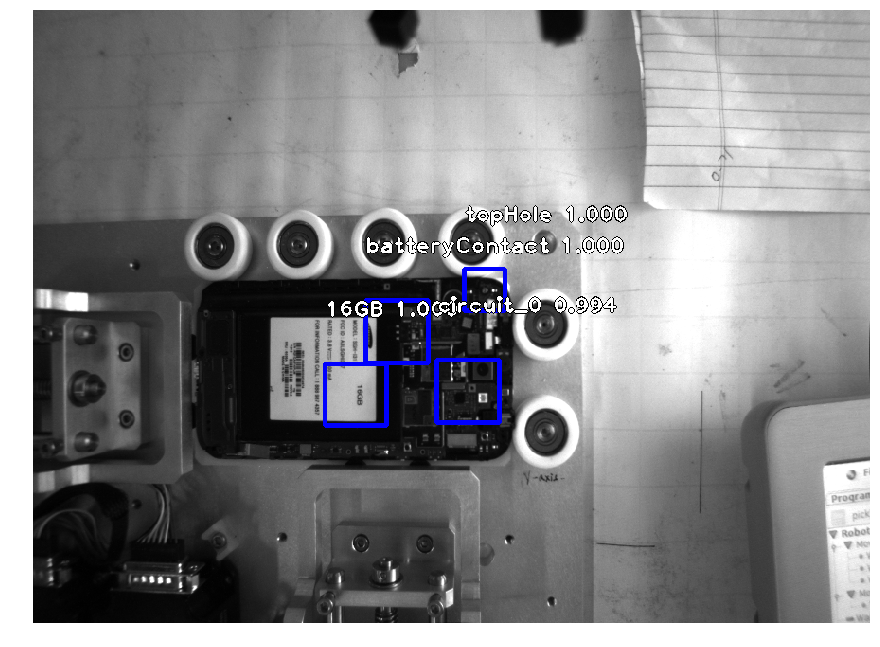

origin and angle 459.0 402.0 0
featureAngle: 16 476 295 0.0549863358187
returning 459.0 402.0 0.0549863358187
initialPos:      459.0 402.0 0.0549863358187
convert origin.png -distort SRT '10,10,1,0,10,10' -alpha off tmp_origin_out.png
0
0.9999200701713562
(15, 7)
25 17
464 399
fine tuned Pos:  464 399 0.0549863358187
sending:   -0.0175,   0.0944,  -0.0240,  0.000,  0.000,  0.001
Waiting for connections...
Connected
received: getCircuitOrigin
( -0.0175,   0.0944,  -0.0240,  0.000,  0.000,  0.001)

Waiting for connections...
Connected
received: acquireCircuitOrigin
(647, 884, 3)
(647, 884, 3)
(600, 820, 3)
0.9273570324574961
processing time:  0.07333588600158691
16 512 279
17 420 325
13 381 393
15 305 454
5 499 384
16 234 455


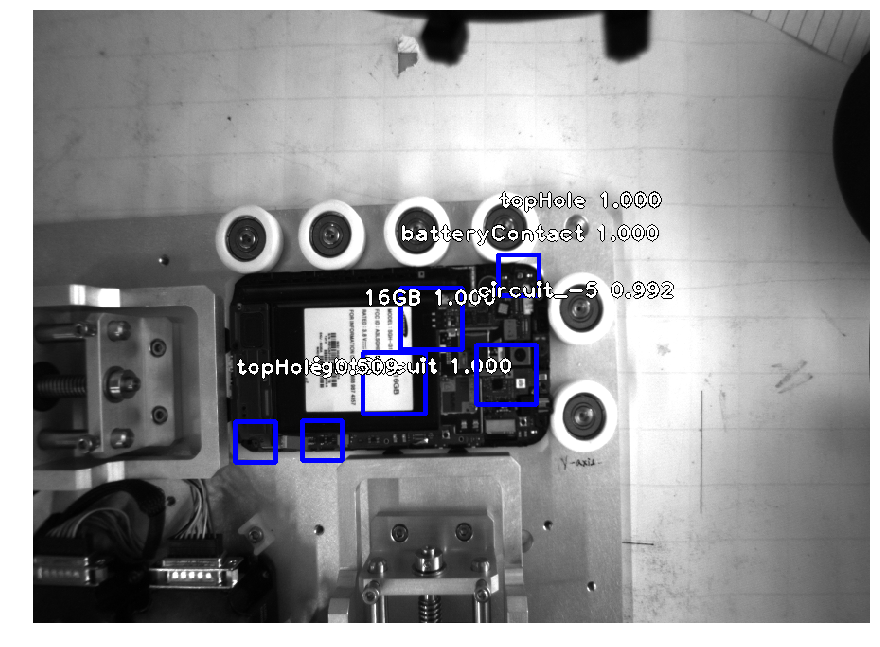

origin and angle 499.5 384.5 -5
featureAngle: 16 234 455 113.843583971
returning 499.5 384.5 113.843583971
initialPos:      499.5 384.5 113.843583971
convert origin.png -distort SRT '10,10,1,114,10,10' -alpha off tmp_origin_out.png
0
0.21885381639003754
(20, 2)
30 12
510 376
fine tuned Pos:  510 376 113.843583971
sending:   -0.0379,   0.1039,  -0.0240,  0.000,  0.000,  1.987
Waiting for connections...
Connected
received: getCircuitOrigin
( -0.0379,   0.1039,  -0.0240,  0.000,  0.000,  1.987)

Waiting for connections...
Connected
received: getCircuitOrigin
( -0.0379,   0.1039,  -0.0240,  0.000,  0.000,  1.987)

Waiting for connections...
Connected
received: getCircuitOrigin
( -0.0379,   0.1039,  -0.0240,  0.000,  0.000,  1.987)

Waiting for connections...
Connected
received: getCircuitOrigin
( -0.0379,   0.1039,  -0.0240,  0.000,  0.000,  1.987)

Waiting for connections...


In [ ]:
finishedLoop = False
while finishedLoop == False:
    print("Waiting for connections...")
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOST, PORT)) # Bind to the port 
    s.listen(5) # Now wait for client connection.
    c, addr = s.accept() # Establish connection with client.
    print("Connected")
    foundError = False
    finishedInner = False
    while foundError == False and finishedInner == False:
        try:
            msg = c.recv(40).decode("utf-8").strip()
            if msg != "":
                print("received: " + msg)
            time.sleep(1)
            if msg == "acquireCircuitOrigin":
                inFileName = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
                x,y,a = get2DPose(inFileName)
                if x == -999:
                    returnVal = "None Found"
                else:    
                    print("initialPos:     ", x, y, a)
                    x, y = getMatchedOrigin(inFileName, int(round(a)), int(round(x)), int(round(y)))
                    print("fine tuned Pos: ", x, y, a)
                    x = (-0.4419 * x + 187.51)/1000.0
                    y = (-0.4141 * y + 259.6)/1000.0
                    z = -24.0/1000.0
                    rx = 0.0
                    ry = 0.0
                    rz = a / 180.0 * math.pi
                    returnVal = "{0:8.4f}, {1:8.4f}, {2:8.4f}, {3:6.3f}, {4:6.3f}, {5:6.3f}".format(x, y, z, rx, ry, rz)
                print("sending: ", returnVal)
                c.send(returnVal.encode())
                finishedInner = True
            elif msg == "getCircuitOrigin":
                returnString = "({})\n".format(returnVal)
                c.send(returnString.encode())
                print(returnString)
                finishedInner = True
            elif msg == "end":
                finishedLoop = True
                finishedInner = True
        except socket.error as socketError:
            print(socketError)
            foundError = True
    c.close()
    s.close()

# Tests

In [16]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

validation_generator = CSVGenerator(
                '/media/kai/Data1/robotPrototype/data/MLRotation/annotation5Tiny.txt',
                '/media/kai/Data1/robotPrototype/data/MLRotation/classname5.txt',
                val_image_data_generator,
                batch_size=10
            )

(647, 884, 3)
(647, 884, 3)
(600, 820, 3)
0.9273570324574961
processing time:  0.078277587890625
16 476 295
17 384 339
13 340 405
6 459 402


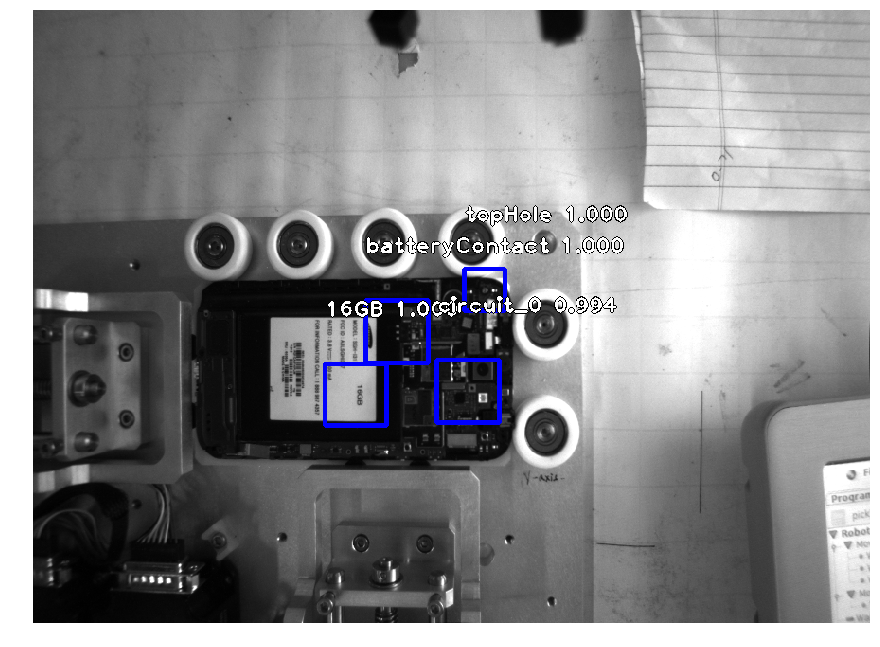

origin and angle 459.0 402.0 0
featureAngle: 16 476 295 0.0549863358187
returning 459.0 402.0 0.0549863358187
/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png 0 459 402
convert origin.png -distort SRT '10,10,1,0,10,10' -alpha off tmp_origin_out.png
0
0.9999200701713562
(15, 7)
25 17
464 399
464 399


In [33]:
testFile = "/media/kai-laptop/study/robot_prototype/ur3Control/tmp/undistorted.png"
result = get2DPose(testFile)
# result = get2DPose("\\\\KAI-LAPTOP\\Users\\kai\\study\\robot_prototype\\ur3Control\\tmp\\undistorted.png")
# result = get2DPose("C:\\Users\\Kai\\study\\robot_prototype\\pyCameraCalibration\\result\\raw\\img65.jpg.png")
print(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))

xResult, yResult = getMatchedOrigin(testFile, int(round(result[2])), int(round(result[0])), int(round(result[1])))
print (xResult, yResult)

In [ ]:
result = get2DPose("/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_400_200_25.png")

In [23]:
testFile = "/media/kai/Data1/robotPrototype/data/MLRotation/resultImg4/out_400_200_25.png"
xResult, yResult = getMatchedOrigin(testFile, 0, 459, 402)

convert origin.png -distort SRT '10,10,1,0,10,10' -alpha off tmp_origin_out.png
0
0.0
(0, 0)
10 10
449 392
